In [79]:
%matplotlib inline
import torch
import pandas as pd
import numpy as np
import gdown
import zipfile
import json
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.transforms.functional import to_pil_image
from torchvision.io import read_image 
import torchvision
import PIL
from sklearn.metrics import confusion_matrix, roc_curve, auc

from tqdm import tqdm
import matplotlib.pyplot as plt


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Download dataset

In [5]:
# gdown.download_folder("https://drive.google.com/drive/folders/19XjDFtOGimZjoRc42moVsJBclKBpoYDQ?usp=sharing")

Retrieving folder list


Processing file 1btEnnyrgC-VFsKcsXh4E9Z4sG-68sEdI rgb-images.zip
Processing file 1A_XLGRv7CMRw-p6OaaiUaiHg5NvQpaFI road_waymo_trainval_v1.0.json
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From (uriginal): https://drive.google.com/uc?id=1btEnnyrgC-VFsKcsXh4E9Z4sG-68sEdI
From (redirected): https://drive.google.com/uc?id=1btEnnyrgC-VFsKcsXh4E9Z4sG-68sEdI&confirm=t&uuid=8550631a-af6f-439e-9012-754c6ff5208d
To: C:\Users\mtang\Desktop\VisionFinal\road-waymo\rgb-images.zip
100%|█████████████████████████████████████| 5.10G/5.10G [10:09<00:00, 8.37MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1A_XLGRv7CMRw-p6OaaiUaiHg5NvQpaFI
From (redirected): https://drive.google.com/uc?id=1A_XLGRv7CMRw-p6OaaiUaiHg5NvQpaFI&confirm=t&uuid=1e8f796d-0c0f-4318-b4a1-85028b2723de
To: C:\Users\mtang\Desktop\VisionFinal\road-waymo\road_waymo_trainval_v1.0.json
100%|█████████████████████████████████████| 1.05G/1.05G [02:19<00:00, 7.57MB/s]
Download completed


['C:\\Users\\mtang\\Desktop\\VisionFinal\\road-waymo\\rgb-images.zip',
 'C:\\Users\\mtang\\Desktop\\VisionFinal\\road-waymo\\road_waymo_trainval_v1.0.json']

In [9]:
# with zipfile.ZipFile("road-waymo/rgb-images.zip","r") as zip_ref:
#     zip_ref.extractall("road-waymo/rgb-images")

In [10]:
with open("road-waymo/road_waymo_trainval_v1.0.json","r") as fp:
    dat = json.load(fp)

In [12]:
# Write a sample to view
sample = dat['db']['train_00017']
with open("road-waymo/sample.json", "w") as fp:
    json.dump(sample,fp)

In [13]:
def has_ped(frame):
    if 'annos' not in frame:
        return False
    for id,anno in frame['annos'].items():
        if 7 in anno['agent_ids']:
            return True
    return False

In [14]:
has_ped(dat['db']['train_00017']['frames']['128'])

False

In [16]:
image_dir = "road-waymo/rgb-images/"
videos = os.listdir(image_dir)

In [17]:
filenames = []
classifications = []
for vid in videos:
    if vid.startswith("."):
        continue
    frames = dat['db'][vid]['frames']
    for frame in frames:
        ped = has_ped(frames[frame])
        filename = f'{vid}/{frame.zfill(5)}'
        
        # skip if image doesn't exist
        fullpath = os.path.join(image_dir, filename+".jpg")
        if not os.path.isfile(fullpath):
            continue 

        filenames.append(filename)
        classifications.append(ped)
        # if ped:
        #     print(f"{vid} {frame}")
labels = pd.DataFrame({"image":filenames, "label":classifications})
labels.to_csv("./processed_labels.csv", index=False)

# Load dataset

In [18]:
def select_equal_samples(data, label_column='label'):
    """ Select equal # of pos/neg samples """
    positive_samples = data[data[label_column] == True]
    negative_samples = data[data[label_column] == False]

    # Determine the number of samples to select (minimum of positive and negative samples)
    num_samples = min(len(positive_samples), len(negative_samples))

    # Randomly select equal number of positive and negative samples without replacement
    selected_positive_samples = positive_samples.sample(n=num_samples, random_state=42, replace=False)
    selected_negative_samples = negative_samples.sample(n=num_samples, random_state=42, replace=False)

    # Concatenate the selected samples
    selected_samples = pd.concat([selected_positive_samples, selected_negative_samples])

    return selected_samples

In [53]:
class PedestrianClassificationDataset(Dataset):

    def __init__(self, labels_csv, root_dir, balance_labels=True, transform=None):
        self.labels = pd.read_csv(labels_csv)
        if balance_labels:
            self.labels = select_equal_samples(self.labels)
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {True: 1, False: 0}
        # self.image_files = sorted(self.labels['image'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.labels.iloc[idx]
        image_name = row['image'] + ".jpg"
        image_name = os.path.join(self.root_dir, image_name) 
        image = read_image(image_name) / 255
        label = self.class_to_idx[row['label']]
        if self.transform:
            image = self.transform(image)
        return (image, label)

Dataset len:  5174
0


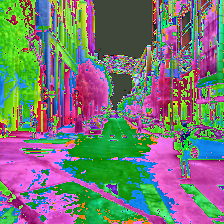

In [57]:
transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=(224, 224), antialias=True),
            torchvision.transforms.Normalize(mean=0.485, std=0.225),])

dataset = PedestrianClassificationDataset("./processed_labels.csv","./road-waymo/rgb-images/", balance_labels=True, transform = transforms)
print(f"Dataset len:  {len(dataset)}")

sample = dataset[5000]
print(sample[1])
to_pil_image(sample[0])

In [58]:
# Split training and testing
train_ratio = 0.8
val_ratio = 0.1

dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

# Use random_split to split the dataset into training and testing sets.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [59]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Experiments

In [73]:
num_epoch = 1 # TODO: change num_epoch to like 10 or 15 or something
def train(model, train_dataloader, val_dataloader, save_path):
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer =  torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    best_accuracy = 0.0
    for epoch in tqdm(range(num_epoch), desc="epochs"):  # loop over the dataset multiple times
        model.train()
        for train_data in tqdm(train_dataloader, desc="training 1 epoch"):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = train_data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            break # TODO: delete this
        
        # Validate
        correct = 0
        total = 0
        model.eval()
        all_predicted = torch.tensor([]).to(device)
        all_labels = torch.tensor([]).to(device)
        all_pred_probs = torch.tensor([]).to(device)
        with torch.no_grad():
            for images, labels in tqdm(val_dataloader, desc="Validating"):
                images = images.to(device)
                labels = labels.to(device)

                # calculate outputs by running images through the network
                outputs = model(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_predicted = torch.cat((all_predicted, predicted))
                all_labels = torch.cat((all_labels, labels))
                all_pred_probs = torch.cat((all_pred_probs, outputs.data))
                break # TODO: delete this


        conf_matrix = confusion_matrix(all_labels.cpu(), all_predicted.cpu())
        print("Val confusion matrix:")
        print(conf_matrix)
        print(f"{conf_matrix[0].sum().item()} frames don't have pedestrian, {conf_matrix[1].sum().item()} frames have pedestrian")
        
        tp = conf_matrix[0,0]
        fp = conf_matrix[1,0]
        fn = conf_matrix[0,1]
        print(f"TP: {tp}, FP: {fp}, FN: {fn}")
        print(f"Precision: {tp/(tp+fp)}, Recall: {tp/(tp+fn)}")

        accuracy = 100 * correct / total
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            print(f"Epoch {epoch}: Saving model to {save_path} with val accuracy {accuracy}%")
            torch.save(model.state_dict(), save_path)

In [74]:
save_path = "./checkpoints/resnet50_RGB_image"

model = torchvision.models.resnet50(weights = None)
model.fc = torch.nn.Linear(in_features=2048, out_features=2, bias=True)
model = torch.nn.DataParallel(model)

try:
    model.load_state_dict(torch.load(save_path))
    print("Successfully Loaded Saved Model")
except Exception as error:
    print("Failed to load Saved Model")
    print(error)
model.to(device)

train(model, train_dataloader, val_dataloader, save_path)

epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Successfully Loaded Saved Model


Validating:   0%|          | 0/9 [00:14<?, ?it/s]
<ipython-input-73-40157e40f419>:60: RuntimeWarning: invalid value encountered in long_scalars
  print(f"Precision: {tp/(tp+fp)}, Recall: {tp/(tp+fn)}")


Val confusion matrix:
[[ 0 30]
 [ 0 34]]
30 frames don't have pedestrian, 34 frames have pedestrian
TP: 0, FP: 0, FN: 30
Precision: nan, Recall: 0.0
Epoch 0: Saving model to ./checkpoints/resnet50_RGB_image with val accuracy 53.125%


epochs: 100%|██████████| 1/1 [01:14<00:00, 74.04s/it]


In [83]:
def test(model, test_dataloader, save_path, test_type):

    correct = 0
    total = 0
    model.eval()
    all_predicted = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    all_pred_probs = torch.tensor([]).to(device)
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader, desc="testing"):
            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(images)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted = torch.cat((all_predicted, predicted))
            all_labels = torch.cat((all_labels, labels))
            all_pred_probs = torch.cat((all_pred_probs, outputs.data))
            break # TODO: remove this

    # Let's say y_true is your true binary labels and y_pred_probs is the predicted probabilities for the positive class
    # You should replace them with your actual variables

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(all_labels.cpu(), all_pred_probs[:,0].cpu(), pos_label=1)
    roc_auc = auc(fpr, tpr)
    print("ROC curve area:", roc_auc)

    # Plotting the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    conf_matrix = confusion_matrix(all_labels.cpu(), all_predicted.cpu())
    print(conf_matrix)
    print(f"{conf_matrix[0].sum().item()} frames don't have pedestrian, {conf_matrix[1].sum().item()} frames have pedestrian")
    tp = conf_matrix[0,0]
    fp = conf_matrix[1,0]
    fn = conf_matrix[0,1]
    print(f"TP: {tp}, FP: {fp}, FN: {fn}")
    print(f"Precision: {tp/(tp+fp)}, Recall: {tp/(tp+fn)}")
    accuracy = 100 * correct / total
    print(f"Accuracy for {save_path}: {accuracy}")
    plt.show()

testing:   0%|          | 0/9 [00:00<?, ?it/s]

Successfully Loaded Saved Model


testing:   0%|          | 0/9 [00:15<?, ?it/s]

ROC curve area: 0.4874874874874875
[[ 1 26]
 [ 1 36]]
27 frames don't have pedestrian, 37 frames have pedestrian
TP: 1, FP: 1, FN: 26
Precision: 0.5, Recall: 0.037037037037037035
Accuracy for ./checkpoints/resnet50_RGB_image: 57.8125


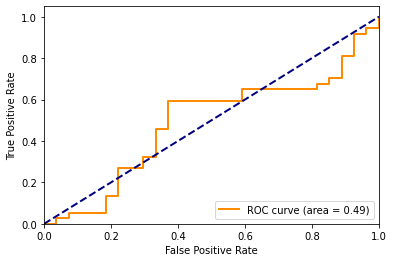

In [84]:
model = torchvision.models.resnet50(weights = None)
model.fc = torch.nn.Linear(in_features=2048, out_features=2, bias=True)
model = torch.nn.DataParallel(model)
try:
    model.load_state_dict(torch.load(save_path))
    print("Successfully Loaded Saved Model")
except Exception as error:
    print("Failed to load Saved Model")
    print(error)
model.to(device)

test(model, test_dataloader, save_path, "RGB")